# Preliminary Data Analysis

Some preliminary data analysis on the data acquired during regen testing on July 6th, between 22:02 and 22:04 (PST).
This notebook takes advantage of the custom `TimeSeries` class, which is a data-analysis centric wrapper around `np.ndarray`.

In [1]:
from data_analysis.data_tools.time_series import TimeSeries
from data_analysis.data_tools.influx_client import InfluxClient

from simulation.common import BrightSide

import matplotlib.pyplot as plt
import numpy as np

# 1st Run
start = "2024-07-16T15:00:00Z"
stop = "2024-07-17T03:00:00Z"

client = InfluxClient()

Query the data, then align their x–axes such that math is well-defined.

In [2]:
motor_voltage: TimeSeries = client.query_time_series(start, stop, "BatteryVoltage", units="V")
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
motor_current_direction: TimeSeries = client.query_time_series(start, stop, "BatteryCurrentDirection", units="")
vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
motor_current, motor_voltage, vehicle_velocity, motor_current_direction = TimeSeries.align(motor_current, motor_voltage, vehicle_velocity, motor_current_direction)
motor_current_signed = motor_current.promote(np.fromiter(map(lambda x: -x[1] if motor_current_direction[x[0]] == 1 else x[1], enumerate(motor_current)), dtype=float))

/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Plot the data to make sure nothing bad or spooky happened (and matches what's seen on InfluxDB Data Explorer).

Now, let's find the time that current is negative (regen is occurring).

In [7]:
# Find indices where regen occurs
current_negative_mask = np.where(motor_current_signed < 0)[0]

# Group consecutive indices to identify regen periods
regen_periods = []
current_period = [current_negative_mask[0]] # Start the first regen period with the first negative current index

for i in range(1, len(current_negative_mask)):
    # If indices are consecutive, extend the current_period
    if current_negative_mask[i] == current_negative_mask[i - 1] + 1:
        current_period.append(current_negative_mask[i]) 
    # If indices are not consecutive, add the list of current_period to regen_periods
    else:
        regen_periods.append(current_period) 
        current_period = [current_negative_mask[i]] # Start a new current_period with index i

regen_periods.append(current_period)  # Add the last current_period to the list of regen periods 

for period in regen_periods:
    # We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
    first_regen_index = period[0]
    last_regen_index = period[-1]

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

In [8]:
regen_periods

[[468, 469, 470, 471, 472],
 [2710, 2711, 2712],
 [2720],
 [2742],
 [2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003],
 [3174,
  3175,
  3176,
  3177,
  3178,
  3179,
  3180,
  3181,
  3182,
  3183,
  3184,
  3185,
  3186,
  3187,
  3188],
 [3577],
 [3587, 3588, 3589, 3590, 3591],
 [3623, 3624, 3625, 3626, 3627, 3628, 3629],
 [3759, 3760, 3761],
 [4007, 4008, 4009, 4010, 4011],
 [4225],
 [4443,
  4444,
  4445,
  4446,
  4447,
  4448,
  4449,
  4450,
  4451,
  4452,
  4453,
  4454,
  4455,
  4456,
  4457,
  4458,
  4459,
  4460,
  4461,
  4462,
  4463,
  4464,
  4465],
 [5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243],
 [5253],
 [5261, 5262, 5263, 5264, 5265],
 [5275],
 [5425],
 [5857, 5858, 5859, 5860, 5861],
 [6970, 6971, 6972, 6973, 6974],
 [7312, 7313, 7314, 7315, 7316],
 [7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334],
 [7606,
  7607,
  7608,
  7609,
  7610,
  7611,
  7612,
  7613,
  7614,
  7615,
  7616,
  7617,
  7618,
  7619,
  7620],
 [7736, 7737, 7738, 7739],
 [779

We can also inspect the change in velocity to get a sense of the change in kinetic energy, estimating a vehicle mass of 300kg.

In [ ]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

for period in regen_periods:
    initial_velocity = vehicle_velocity[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity[period[-1]]                                 # Units: m/s
    kinetic_energy  = lambda vi, vf: 0.5 * BrightSide.vehicle_mass * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    # print(f"Initial Velocity for Period {period_index}: {initial_velocity:.4f} {vehicle_velocity.units}")
    # print(f"Final Velocity for Period {period_index}: {final_velocity:.4f} {vehicle_velocity.units}")
    # print(f"Change in Kinetic Energy for Period {period_index}: {delta_kinetic_energy:.4f} J")

    period_index += 1

Now, let's calculate the battery power during regen.
Note: the elementwise-array multiplication returns an `ndarray`, so I use `regen_current.promote()` on the result to get back a `TimeSeries`.

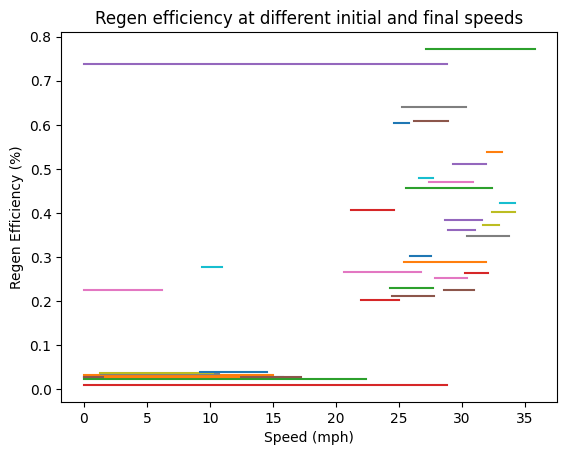

In [36]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

fig, ax = plt.subplots()

for period in regen_periods:
    if len(period) < 10:
        period_index += 1
        continue

    first_regen_index = period[0]
    last_regen_index = period[-1]

    initial_velocity = vehicle_velocity[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity[period[-1]]                                 # Units: m/s

    if (abs(final_velocity - initial_velocity) < 0.5) or (final_velocity > initial_velocity):
        period_index += 1
        continue

    kinetic_energy  = lambda vi, vf: 0.5 * BrightSide.vehicle_mass * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

    regen_power = regen_current.promote(regen_current * regen_voltage)
    regen_power.units = "W"  # Fix units after math
    regen_power.meta["field"] = "Pack Power"

    regen_energy = np.trapz(regen_power, regen_power.x_axis)  # Units: J
    efficiency: float = regen_energy / delta_kinetic_energy

    if efficiency > 1:
        period_index += 1
        continue

    period_index += 1
    ax.plot([final_velocity * 3.6 / 1.609, initial_velocity * 3.6 / 1.609], [efficiency, efficiency])

ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Regen Efficiency (%)")
ax.set_title("Regen efficiency at different initial and final speeds")

plt.show()

Now, let's integrate with respect to time to get regen energy, and then get efficiency.